In [404]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import statsmodels.api as sm
from scipy import stats

from prophet import Prophet

In [405]:
sales_data = pd.read_csv('shop_sales.csv')
calendar_data = pd.read_csv('shop_sales_dates.csv')
prices_data = pd.read_csv('shop_sales_prices.csv')

In [406]:
prices_data

,store_id,item_id,wm_yr_wk,sell_price
0,STORE_2,STORE_2_085,11101,1.00
1,STORE_2,STORE_2_043,11101,2.88
2,STORE_2,STORE_2_054,11101,2.28
3,STORE_2,STORE_2_090,11101,1.25
4,STORE_2,STORE_2_252,11101,1.48
...,...,...,...,...
11136,STORE_1,STORE_1_584,11551,1.00
11137,STORE_1,STORE_1_586,11551,1.68
11138,STORE_1,STORE_1_587,11551,2.48
11139,STORE_1,STORE_1_714,11551,1.58


In [407]:
sales_data

,item_id,store_id,date_id,cnt
0,STORE_2_085,STORE_2,1,3
1,STORE_2_085,STORE_2,2,8
2,STORE_2_085,STORE_2,3,0
3,STORE_2_085,STORE_2,4,3
4,STORE_2_085,STORE_2,5,0
...,...,...,...,...
81850,STORE_1_727,STORE_1,1815,2
81851,STORE_1_727,STORE_1,1816,3
81852,STORE_1_727,STORE_1,1817,1
81853,STORE_1_727,STORE_1,1818,4


In [408]:
sales_data['week_id'] = (sales_data['date_id'] - 1) // 7 + 11101

# Объединение таблиц по item_id, store_id и соответствующим неделям
merged_data = pd.merge(sales_data, prices_data, how='left', 
                       left_on=['store_id', 'item_id', 'week_id'], 
                       right_on=['store_id', 'item_id', 'wm_yr_wk'])

# Удаление лишних столбцов
merged_data.drop(columns=['wm_yr_wk'], inplace=True)

In [409]:
merged_data

,item_id,store_id,date_id,cnt,week_id,sell_price
0,STORE_2_085,STORE_2,1,3,11101,1.0
1,STORE_2_085,STORE_2,2,8,11101,1.0
2,STORE_2_085,STORE_2,3,0,11101,1.0
3,STORE_2_085,STORE_2,4,3,11101,1.0
4,STORE_2_085,STORE_2,5,0,11101,1.0
...,...,...,...,...,...,...
81850,STORE_1_727,STORE_1,1815,2,11360,NaN
81851,STORE_1_727,STORE_1,1816,3,11360,NaN
81852,STORE_1_727,STORE_1,1817,1,11360,NaN
81853,STORE_1_727,STORE_1,1818,4,11360,NaN


In [410]:
customer = merged_data[(merged_data['store_id'] == 'STORE_1') & (merged_data['item_id'] == f'STORE_1_555')]
customer = pd.merge(customer, calendar_data, on='date_id', how='inner')
customer = customer.rename(columns={'date': 'ds', 'cnt': 'y'})
customer['sell_price'].interpolate(method='linear', inplace=True)
customer = customer[['ds', 'y', 'sell_price']]
customer['ds'] = pd.to_datetime(customer['ds'])
customer

,ds,y,sell_price
0,2011-01-29,51,1.48
1,2011-01-30,45,1.48
2,2011-01-31,25,1.48
3,2011-02-01,39,1.48
4,2011-02-02,23,1.48
...,...,...,...
1814,2016-01-17,17,1.58
1815,2016-01-18,9,1.58
1816,2016-01-19,15,1.58
1817,2016-01-20,22,1.58


In [411]:
# Объединение столбцов event_name_1 и event_name_2
calendar_data['event'] = calendar_data['event_name_1'].combine_first(calendar_data['event_name_2'])

# Удаление строк, где нет праздников
holidays_data = calendar_data.dropna(subset=['event'])

# Преобразование в формат, подходящий для Prophet
holidays = holidays_data[['date', 'event']]

holidays = holidays.rename(columns={'date': 'ds', 'event': 'holiday'})


In [412]:
holidays

,ds,holiday
8,2011-02-06,SuperBowl
16,2011-02-14,ValentinesDay
23,2011-02-21,PresidentsDay
39,2011-03-09,LentStart
46,2011-03-16,LentWeek2
...,...,...
1780,2015-12-14,Chanukah End
1791,2015-12-25,Christmas
1798,2016-01-01,NewYear
1804,2016-01-07,OrthodoxChristmas


<Axes: >

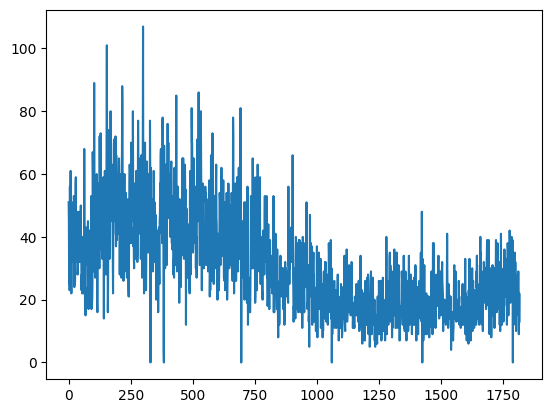

In [413]:
customer['y'].plot()

## Train test split

In [414]:
test_size = 30

customer_train = customer.iloc[:-test_size]
customer_test = customer.iloc[-test_size:]

In [415]:
m = Prophet(holidays=holidays) #, growth='linear', seasonality_mode='additive', holidays_prior_scale=20, seasonality_prior_scale=20
m.add_regressor('sell_price')
model = m.fit(customer_train)

10:35:19 - cmdstanpy - INFO - Chain [1] start processing
10:35:19 - cmdstanpy - INFO - Chain [1] done processing


## Forecast

In [416]:
# Прогноз на будущее
future = m.make_future_dataframe(periods=30, freq='D')

# Создание будущего датафрейма с регрессором
future = pd.merge(future, customer[['ds', 'sell_price']], on='ds', how='left')

# Заполнение пропущенных значений в будущем датафрейме
future['sell_price'].interpolate(method='linear', inplace=True)

# Прогнозирование
forecast = m.predict(future)

forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Chanukah End,Chanukah End_lower,Chanukah End_upper,Christmas,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2011-01-29,37.721887,34.721278,57.166854,37.721887,37.721887,0.0,0.0,0.0,0.0,...,9.488057,9.488057,9.488057,-2.873397,-2.873397,-2.873397,0.0,0.0,0.0,45.768958
1,2011-01-30,37.751355,28.332838,50.794802,37.751355,37.751355,0.0,0.0,0.0,0.0,...,3.169019,3.169019,3.169019,-2.322546,-2.322546,-2.322546,0.0,0.0,0.0,40.030239
2,2011-01-31,37.780824,21.545322,44.750953,37.780824,37.780824,0.0,0.0,0.0,0.0,...,-4.053747,-4.053747,-4.053747,-1.776340,-1.776340,-1.776340,0.0,0.0,0.0,33.383148
3,2011-02-01,37.810292,22.750553,46.097836,37.810292,37.810292,0.0,0.0,0.0,0.0,...,-3.831705,-3.831705,-3.831705,-1.240636,-1.240636,-1.240636,0.0,0.0,0.0,34.170363
4,2011-02-02,37.839761,22.354261,45.426056,37.839761,37.839761,0.0,0.0,0.0,0.0,...,-5.154322,-5.154322,-5.154322,-0.720705,-0.720705,-0.720705,0.0,0.0,0.0,33.397146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1814,2016-01-17,23.432562,7.005515,30.265392,23.412918,23.459422,0.0,0.0,0.0,0.0,...,3.169019,3.169019,3.169019,-7.358485,-7.358485,-7.358485,0.0,0.0,0.0,18.276084
1815,2016-01-18,23.442526,-0.544834,22.029180,23.421835,23.471683,0.0,0.0,0.0,0.0,...,-4.053747,-4.053747,-4.053747,-7.298397,-7.298397,-7.298397,0.0,0.0,0.0,10.246077
1816,2016-01-19,23.452491,0.417733,24.019154,23.428276,23.484689,0.0,0.0,0.0,0.0,...,-3.831705,-3.831705,-3.831705,-7.166017,-7.166017,-7.166017,0.0,0.0,0.0,11.487758
1817,2016-01-20,23.462456,-1.459960,22.517398,23.435429,23.499099,0.0,0.0,0.0,0.0,...,-5.154322,-5.154322,-5.154322,-6.964884,-6.964884,-6.964884,0.0,0.0,0.0,10.376239


<Axes: >

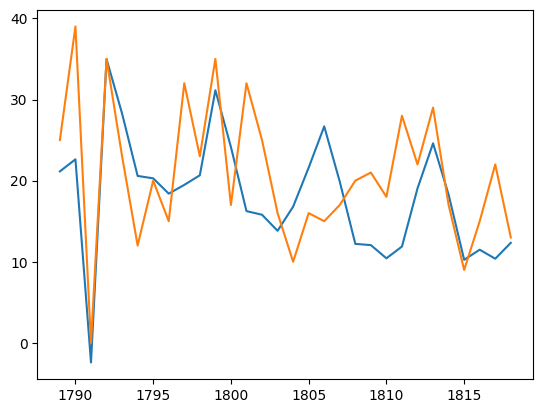

In [417]:
forecast['yhat'].tail(30).plot()
customer_test['y'].plot()

In [418]:
metrics_report(customer_test['y'], forecast['yhat'].tail(30))


,mean,median,quan_75,quan_95,std
maes,6.208454,4.831363,8.852917,15.956174,4.809186
maes_zero,6.746667,5.200000,10.200000,16.500000,5.294026
mapes,inf,29.211881,42.460554,75.024217,NaN
mapes_zero,inf,28.997845,40.142857,119.650000,NaN
r2,0.161242,0.161242,0.161242,0.161242,0.161242


In [419]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [420]:
mean_absolute_percentage_error(customer_test['y'], forecast['yhat'].tail(30))

inf

In [541]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pickle
import os

class RetailSalesPredictor:
    def __init__(self, sales_data, calendar_data, prices_data):
        self.sales_data = sales_data
        self.calendar_data = calendar_data
        self.prices_data = prices_data

    def preprocess_data(self, store_id, item_id):
        # Вычисление week_id
        self.sales_data['week_id'] = (self.sales_data['date_id'] - 1) // 7 + 11101

        # Объединение таблиц
        merged_data = pd.merge(self.sales_data, self.prices_data, how='left', 
                               left_on=['store_id', 'item_id', 'week_id'], 
                               right_on=['store_id', 'item_id', 'wm_yr_wk'])
        merged_data.drop(columns=['wm_yr_wk'], inplace=True)

        customer = merged_data[(merged_data['store_id'] == store_id) & (merged_data['item_id'] == item_id)]
        customer = pd.merge(customer, self.calendar_data, on='date_id', how='inner')
        customer = customer.rename(columns={'date': 'ds', 'cnt': 'y'})
        customer['sell_price'].interpolate(method='linear', inplace=True)
        customer = customer[['ds', 'y', 'sell_price']]
        customer['ds'] = pd.to_datetime(customer['ds'])

        # Объединение столбцов event_name_1 и event_name_2
        self.calendar_data['event'] = self.calendar_data['event_name_1'].combine_first(self.calendar_data['event_name_2'])
        
        # Удаление строк, где нет праздников
        holidays_data = self.calendar_data.dropna(subset=['event'])
        
        # Преобразование в формат, подходящий для Prophet
        holidays = holidays_data[['date', 'event']].rename(columns={'date': 'ds', 'event': 'holiday'})
        
        return customer, holidays

    def train_model(self, sales_data, holidays, test_size=30):
        if len(sales_data) <= test_size:
            raise ValueError("Not enough data to train the model. Please provide more data.")

        train_data = sales_data.iloc[:-test_size]
        test_data = sales_data.iloc[-test_size:]

        if len(train_data) < 2:
            raise ValueError("Not enough data to train the model. Please provide more data.")

        model = Prophet(holidays=holidays, yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
        model.add_regressor('sell_price')
        model.add_seasonality(name='monthly', period=30.5, fourier_order=5)  # Добавление месячной сезонности
        model.fit(train_data)

        return model, train_data, test_data

    def predict_and_evaluate(self, model, sales_data, test_data):
        future = model.make_future_dataframe(periods=len(test_data))
        future = future.merge(sales_data[['ds', 'sell_price']], on='ds', how='left')

        # Заполнение пропущенных значений в будущем датафрейме
        future['sell_price'].interpolate(method='linear', inplace=True)

        forecast = model.predict(future)
        forecast['yhat'] = forecast['yhat'].clip(lower=0)  # Ensure no negative predictions
        predicted = forecast[['ds', 'yhat']].tail(len(test_data))

        actual = test_data['y'].values
        predicted_values = predicted['yhat'].values

        mse = mean_squared_error(actual, predicted_values)
        mae = mean_absolute_error(actual, predicted_values)
        rmse = np.sqrt(mse)  # Рассчет RMSE

        # print(f'Mean Squared Error: {mse}')
        # print(f'Mean Absolute Error: {mae}')
        # print(f'Root Mean Squared Error: {rmse}')

        fig1 = model.plot(forecast)
        plt.show()

        fig2 = model.plot_components(forecast)
        plt.show()

        # Визуализация тестовой части и предсказанных данных
        plt.figure(figsize=(10, 6))
        plt.plot(test_data['ds'], actual, label='Actual', marker='o')
        plt.plot(predicted['ds'], predicted_values, label='Predicted', marker='x')
        plt.title('Actual vs Predicted Sales')
        plt.xlabel('Date')
        plt.ylabel('Sales')
        plt.legend()
        plt.show()

        return mse, mae, rmse

    def save_model(self, model, filename):
        with open(filename, 'wb') as file:
            pickle.dump(model, file)

    def load_model(self, filename):
        with open(filename, 'rb') as file:
            model = pickle.load(file)
        return model

    def forecast_period(self, store_id, item_id, period):
        sales_data, holidays = self.preprocess_data(store_id, item_id)
        available_data = len(sales_data)
        test_size = min(period, available_data - 2)  # Убедимся, что у нас достаточно данных для тренировки и тестирования
        if test_size < 1:
            raise ValueError("Not enough data to train the model for this period. Please provide more data.")
        model, train_data, test_data = self.train_model(sales_data, holidays, test_size=test_size)
        mse, mae, rmse = self.predict_and_evaluate(model, sales_data, test_data)
        return model, mse, mae, rmse

    def forecast_future(self, store_id, item_id, period):
        sales_data, holidays = self.preprocess_data(store_id, item_id)
        if len(sales_data) < 2:
            raise ValueError("Not enough data to forecast the future.")
        
        # Fill NaN values in the 'sell_price' column
        sales_data['sell_price'].fillna(method='ffill', inplace=True)
        
        train_data = sales_data.copy()
        model = Prophet(holidays=holidays)
        model.add_regressor('sell_price')
        model.add_seasonality(name='monthly', period=30.5, fourier_order=5)  # Добавление месячной сезонности
        model.fit(train_data)
        
        future = model.make_future_dataframe(periods=period)
        future = future.merge(sales_data[['ds', 'sell_price']], on='ds', how='left')
        
        # Fill NaN values in the 'sell_price' column in future data
        future['sell_price'].interpolate(method='linear', inplace=True)
        
        forecast = model.predict(future)
        forecast['yhat'] = forecast['yhat'].clip(lower=0)  # Ensure no negative predictions
        predicted = forecast[['ds', 'yhat']].tail(period)
        
        return predicted

    def forecast_week(self, store_id, item_id):
        return self.forecast_period(store_id, item_id, period=7)

    def forecast_month(self, store_id, item_id):
        return self.forecast_period(store_id, item_id, period=30)

    def forecast_quarter(self, store_id, item_id):
        return self.forecast_period(store_id, item_id, period=90)

    def predict_week(self, store_id, item_id):
        return self.forecast_future(store_id, item_id, period=7)

    def predict_month(self, store_id, item_id):
        return self.forecast_future(store_id, item_id, period=30)

    def predict_quarter(self, store_id, item_id):
        return self.forecast_future(store_id, item_id, period=90)


In [433]:
prices_data = pd.read_csv('test data/shop_sales_prices_test.csv')
prices_data[(prices_data['store_id'] == 'STORE_1')]['item_id'].unique()

array(['STORE_1_064', 'STORE_1_065', 'STORE_1_325', 'STORE_1_376',
       'STORE_1_090', 'STORE_1_252', 'STORE_1_339', 'STORE_1_546',
       'STORE_1_547', 'STORE_1_555', 'STORE_1_584', 'STORE_1_586',
       'STORE_1_587', 'STORE_1_714', 'STORE_1_727'], dtype=object)

# Товар

In [551]:
ID_ITEM = 'STORE_1_064'

15:10:47 - cmdstanpy - INFO - Chain [1] start processing
15:10:47 - cmdstanpy - INFO - Chain [1] done processing


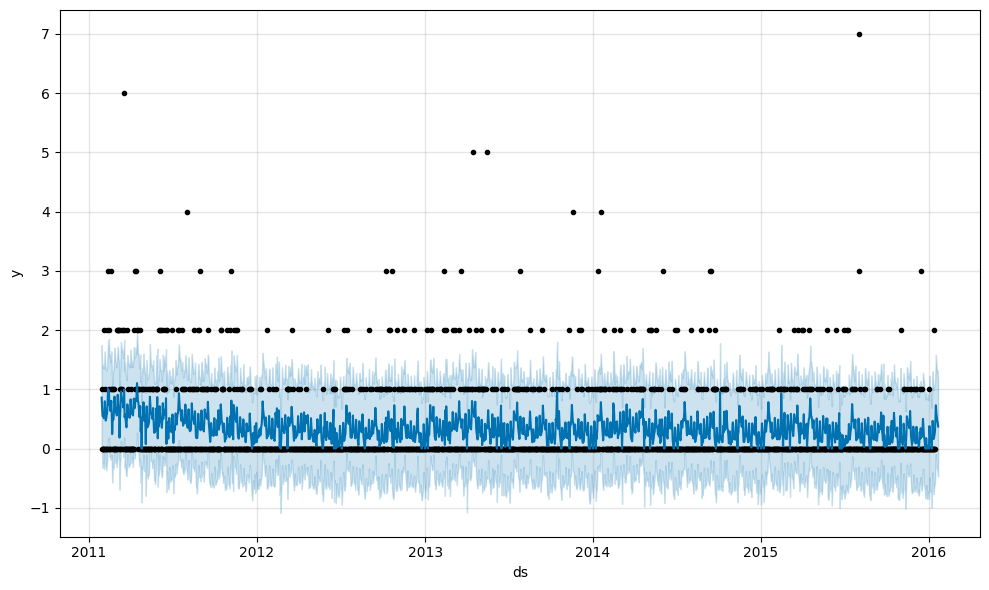

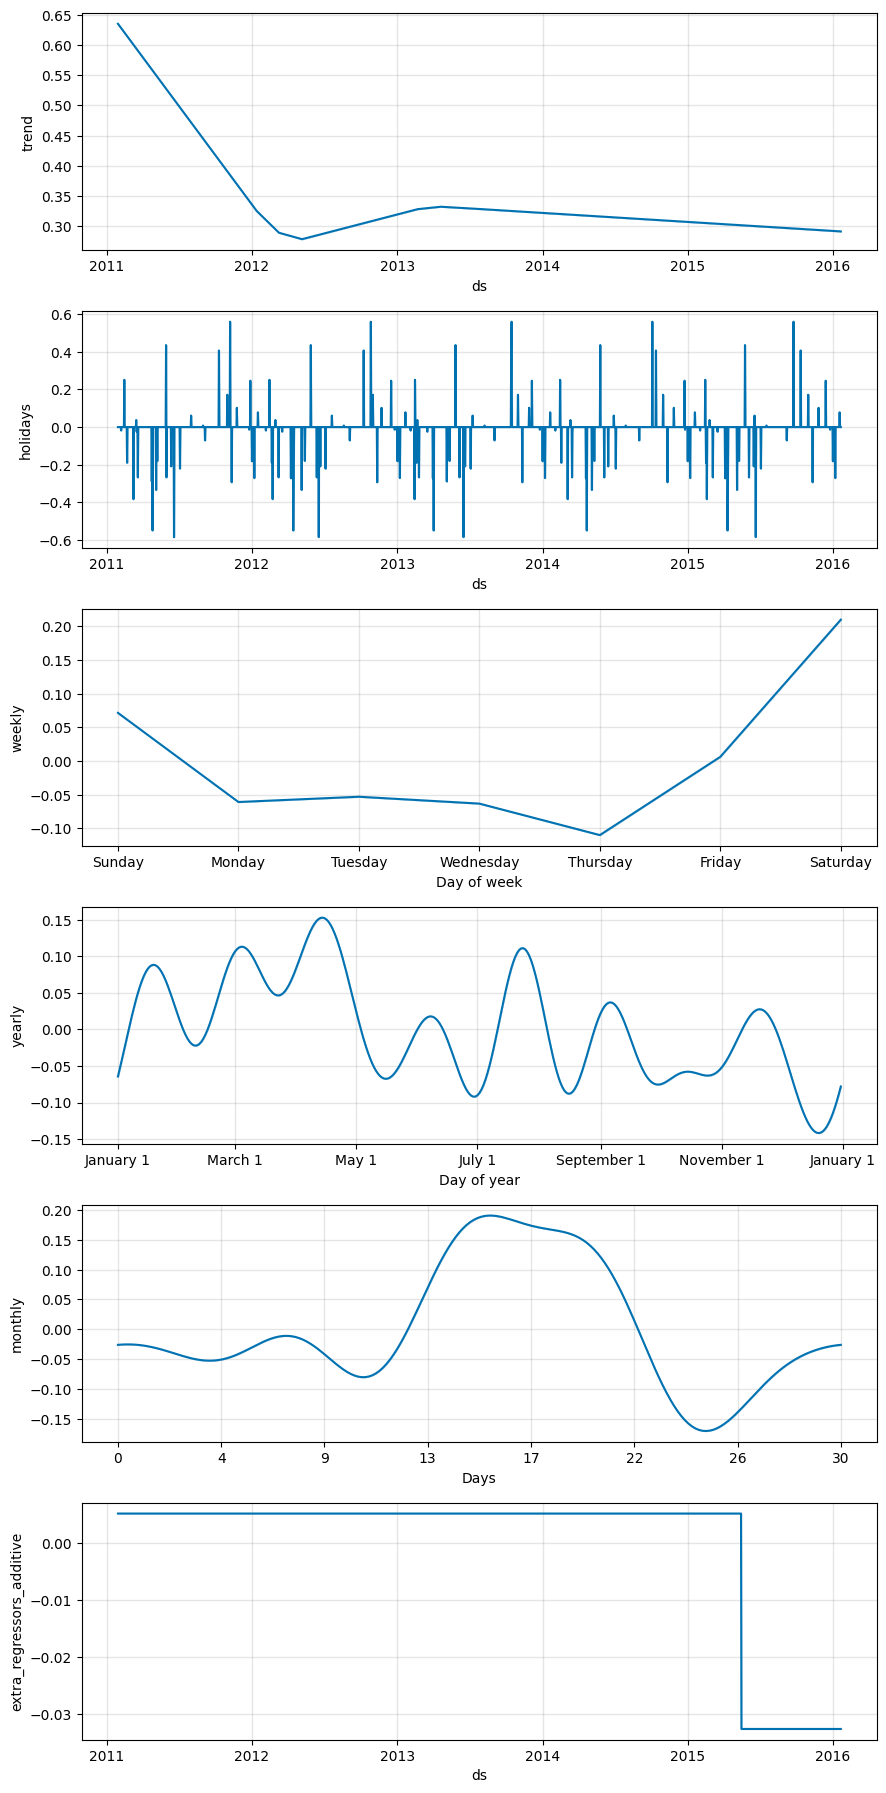

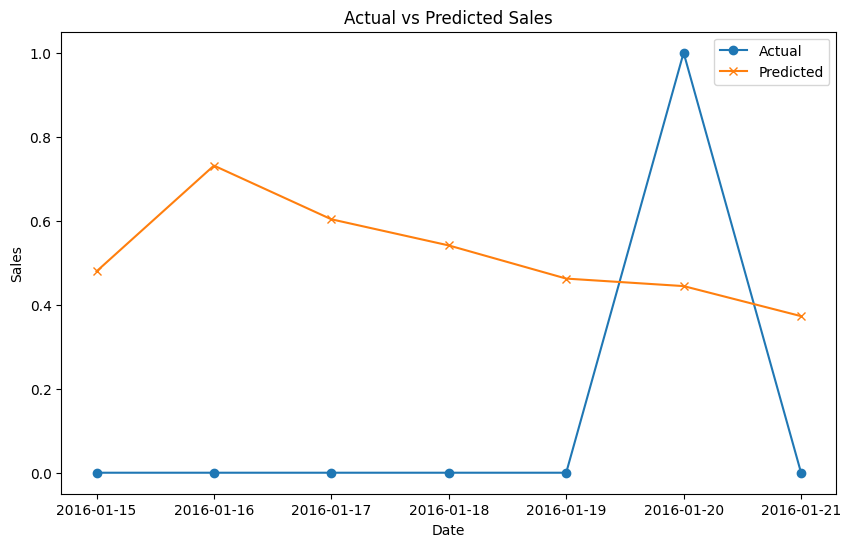

Week - MSE: 0.2975565742264451, MAE: 0.535130770021694, RSME: 0.5454874647748059


15:10:50 - cmdstanpy - INFO - Chain [1] start processing
15:10:50 - cmdstanpy - INFO - Chain [1] done processing


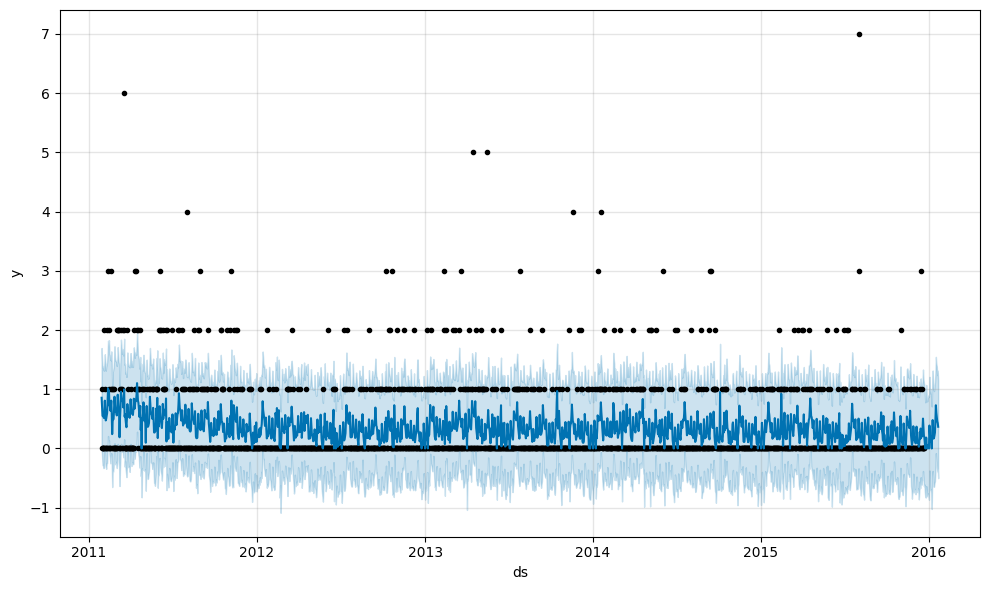

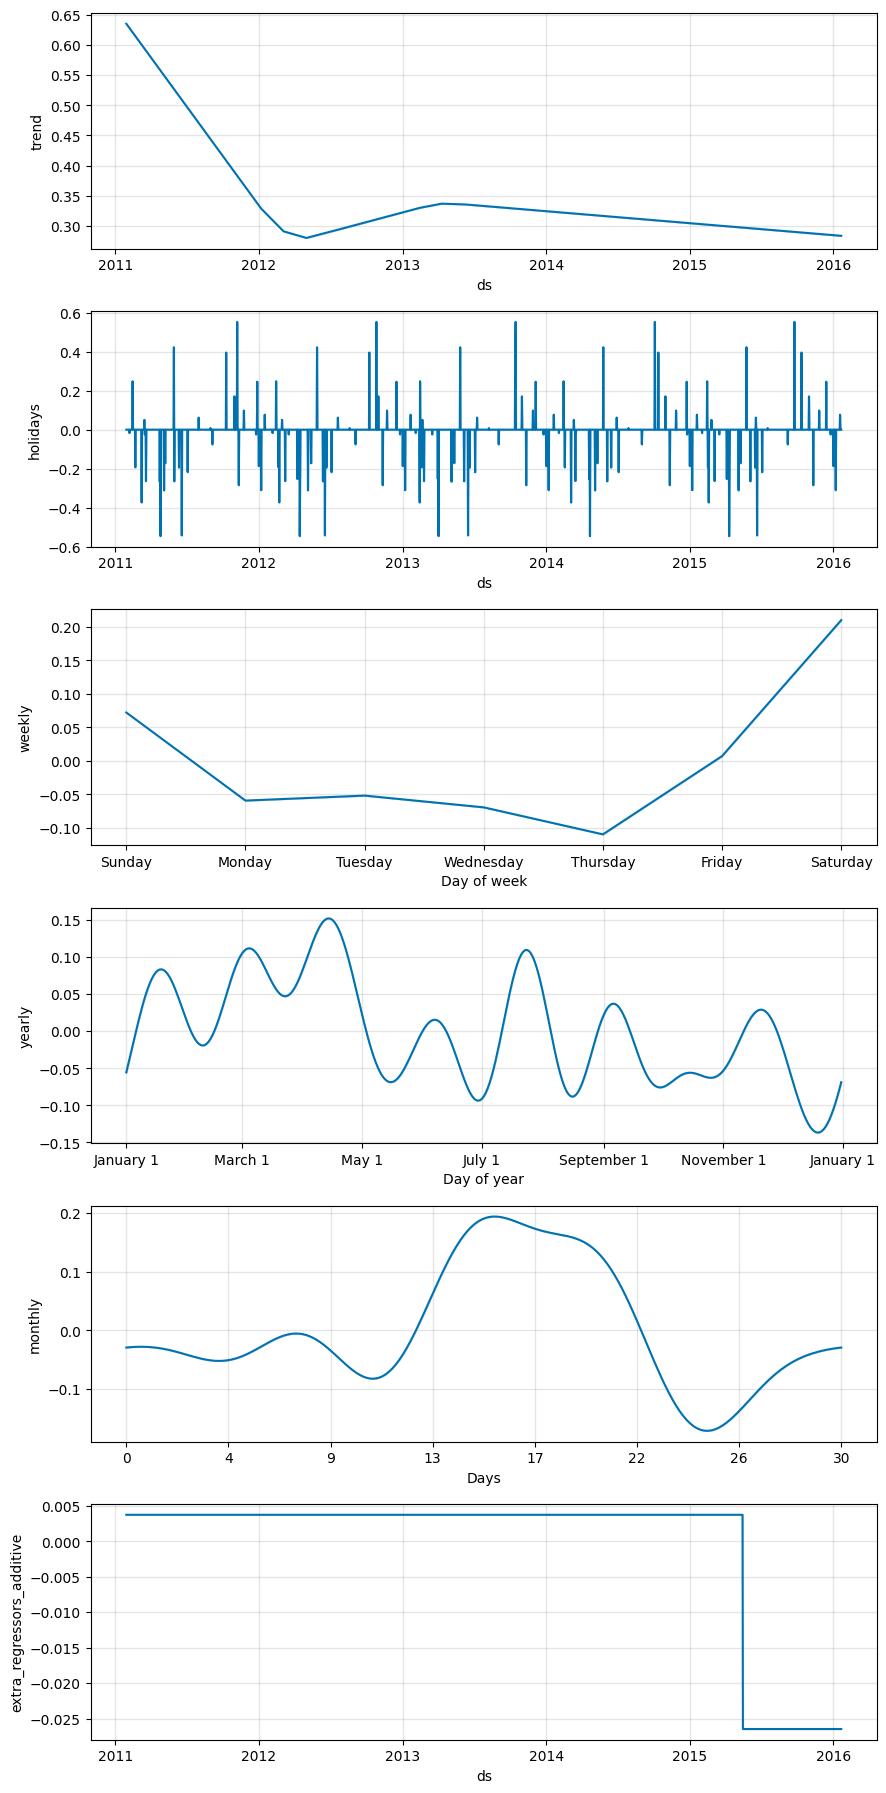

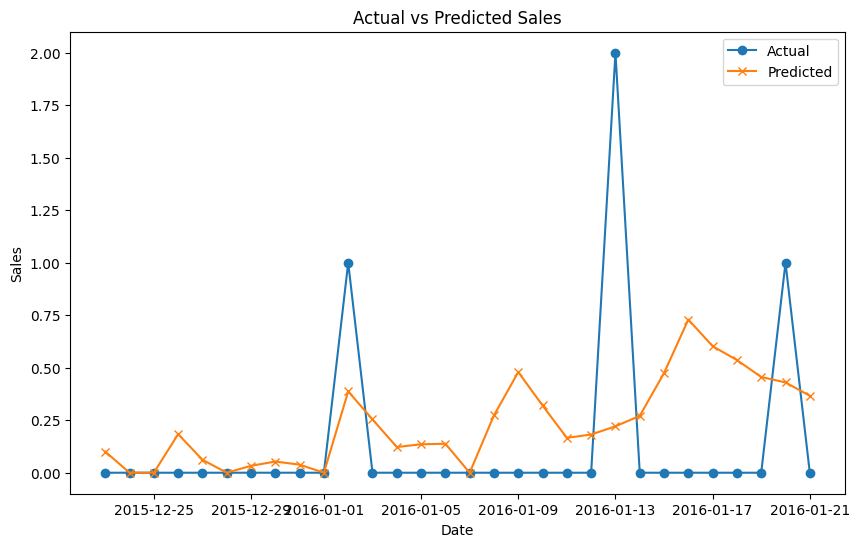

Month - MSE: 0.2108808661662198, MAE: 0.29795529633481854, RSME: 0.45921766752404003


15:10:53 - cmdstanpy - INFO - Chain [1] start processing
15:10:54 - cmdstanpy - INFO - Chain [1] done processing


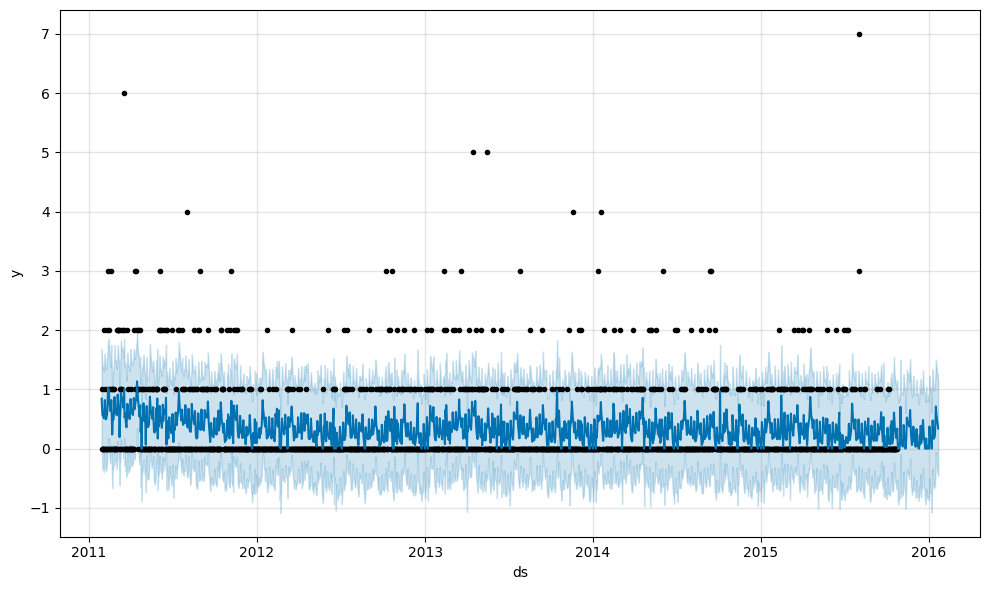

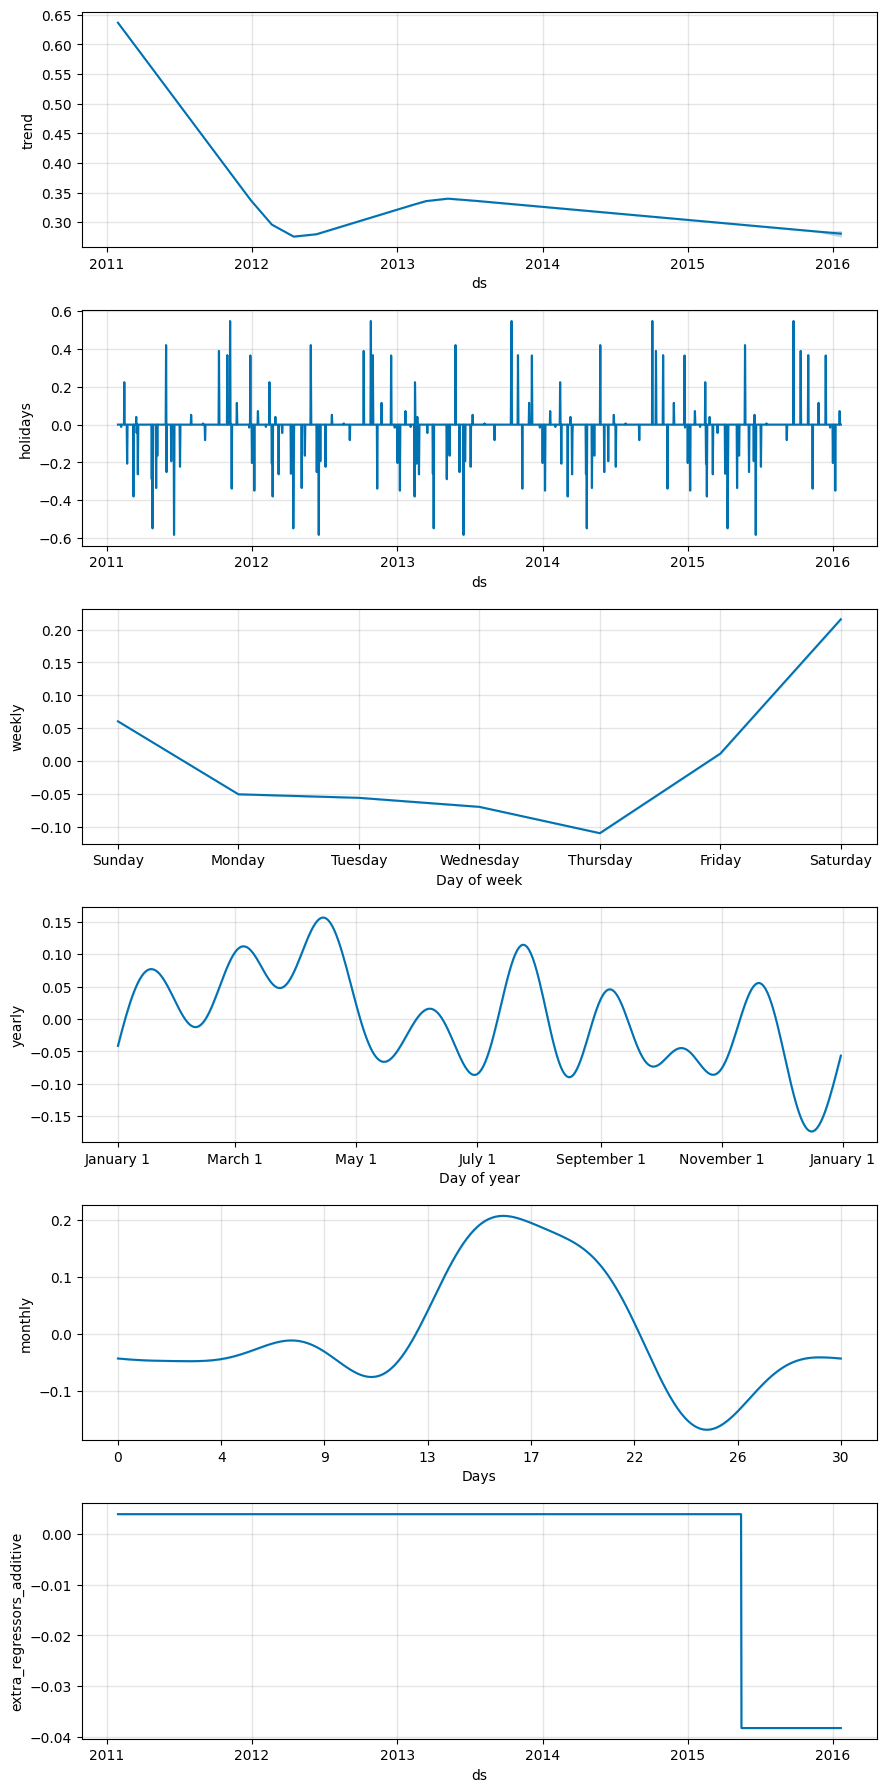

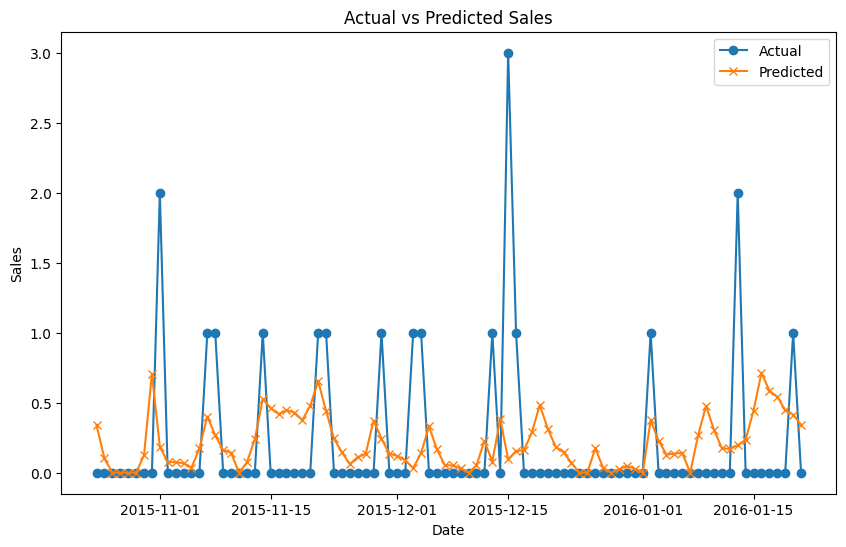

Quarter - MSE: 0.29424151323282416, MAE: 0.3305347781471664, RSME: 0.542440331495386


15:10:56 - cmdstanpy - INFO - Chain [1] start processing
15:10:57 - cmdstanpy - INFO - Chain [1] done processing
15:10:57 - cmdstanpy - INFO - Chain [1] start processing


Future Week Predictions:              ds      yhat
1819 2016-01-22  0.397469
1820 2016-01-23  0.511046
1821 2016-01-24  0.278433
1822 2016-01-25  0.089470
1823 2016-01-26  0.075512
1824 2016-01-27  0.088686
1825 2016-01-28  0.073102


15:10:57 - cmdstanpy - INFO - Chain [1] done processing
15:10:58 - cmdstanpy - INFO - Chain [1] start processing


Future Month Predictions:              ds      yhat
1819 2016-01-22  0.397469
1820 2016-01-23  0.511046
1821 2016-01-24  0.278433
1822 2016-01-25  0.089470
1823 2016-01-26  0.075512
1824 2016-01-27  0.088686
1825 2016-01-28  0.073102
1826 2016-01-29  0.220730
1827 2016-01-30  0.442081
1828 2016-01-31  0.308393
1829 2016-02-01  0.179233
1830 2016-02-02  0.170657
1831 2016-02-03  0.145931
1832 2016-02-04  0.080100
1833 2016-02-05  0.194812
1834 2016-02-06  0.409958
1835 2016-02-07  0.283863
1836 2016-02-08  0.156509
1837 2016-02-09  0.136718
1838 2016-02-10  0.099167
1839 2016-02-11  0.038523
1840 2016-02-12  0.187760
1841 2016-02-13  0.461845
1842 2016-02-14  0.403753
1843 2016-02-15  0.339455
1844 2016-02-16  0.370835
1845 2016-02-17  0.368303
1846 2016-02-18  0.317619
1847 2016-02-19  0.438321
1848 2016-02-20  0.637208


15:10:58 - cmdstanpy - INFO - Chain [1] done processing


Future Quarter Predictions:              ds      yhat
1819 2016-01-22  0.397469
1820 2016-01-23  0.511046
1821 2016-01-24  0.278433
1822 2016-01-25  0.089470
1823 2016-01-26  0.075512
...         ...       ...
1904 2016-04-16  0.754673
1905 2016-04-17  0.632003
1906 2016-04-18  0.498512
1907 2016-04-19  0.489894
1908 2016-04-20  0.474050

[90 rows x 2 columns]


In [552]:
# Загрузка данных
sales_data = pd.read_csv('shop_sales.csv')
calendar_data = pd.read_csv('shop_sales_dates.csv')
prices_data = pd.read_csv('shop_sales_prices.csv')

# Создание экземпляра класса RetailSalesPredictor
predictor = RetailSalesPredictor(sales_data, calendar_data, prices_data)

# Оценка качества модели на тренировочной выборке
model_week, mse_week, mae_week, rmse_week = predictor.forecast_week('STORE_1', ID_ITEM)
print(f'Week - MSE: {mse_week}, MAE: {mae_week}, RSME: {rmse_week}')

model_month, mse_month, mae_month, rmse_month = predictor.forecast_month('STORE_1', ID_ITEM)
print(f'Month - MSE: {mse_month}, MAE: {mae_month}, RSME: {rmse_month}')

model_quarter, mse_quarter, mae_quarter, rmse_quarter = predictor.forecast_quarter('STORE_1', ID_ITEM)
print(f'Quarter - MSE: {mse_quarter}, MAE: {mae_quarter}, RSME: {rmse_quarter}')

# Предсказание будущих значений
future_week = predictor.predict_week('STORE_1', ID_ITEM)
print(f'Future Week Predictions: {future_week}')

future_month = predictor.predict_month('STORE_1', ID_ITEM)
print(f'Future Month Predictions: {future_month}')

future_quarter = predictor.predict_quarter('STORE_1', ID_ITEM)
print(f'Future Quarter Predictions: {future_quarter}')

# Сохранение модели
predictor.save_model(model_week, 'model_week.pkl')
predictor.save_model(model_month, 'model_month.pkl')
predictor.save_model(model_quarter, 'model_quarter.pkl')

# Загрузка модели
loaded_model_week = predictor.load_model('model_week.pkl')
loaded_model_month = predictor.load_model('model_month.pkl')
loaded_model_quarter = predictor.load_model('model_quarter.pkl')


# Тестовые данные и Валидация

In [544]:
test_sales = pd.read_csv('test data/shop_sales_test.csv')
calendar_test = pd.read_csv('test data/shop_sales_dates_test.csv')

### Товар

In [546]:
ID_ITEM = 'STORE_1_586'

In [547]:
test_store = test_sales[(test_sales['store_id'] == 'STORE_1') & (test_sales['item_id'] == ID_ITEM)]
test_store = pd.merge(test_store, calendar_test, on='date_id', how='inner')
test_store = test_store.rename(columns={'date': 'ds', 'cnt': 'y'})
test_store = test_store[['ds', 'y']]
test_store['ds'] = pd.to_datetime(test_store['ds'])
test_store.head(5)

,ds,y
0,2016-01-22,21
1,2016-01-23,32
2,2016-01-24,30
3,2016-01-25,16
4,2016-01-26,9


In [548]:
future = future_quarter

In [549]:
future.head(5)

,ds,yhat
1819,2016-01-22,27.041710
1820,2016-01-23,34.661625
1821,2016-01-24,31.771007
1822,2016-01-25,18.584927
1823,2016-01-26,18.533578


MAE: 6.365753984103569
RMSE: 7.794026190116085
MAPE: nan%


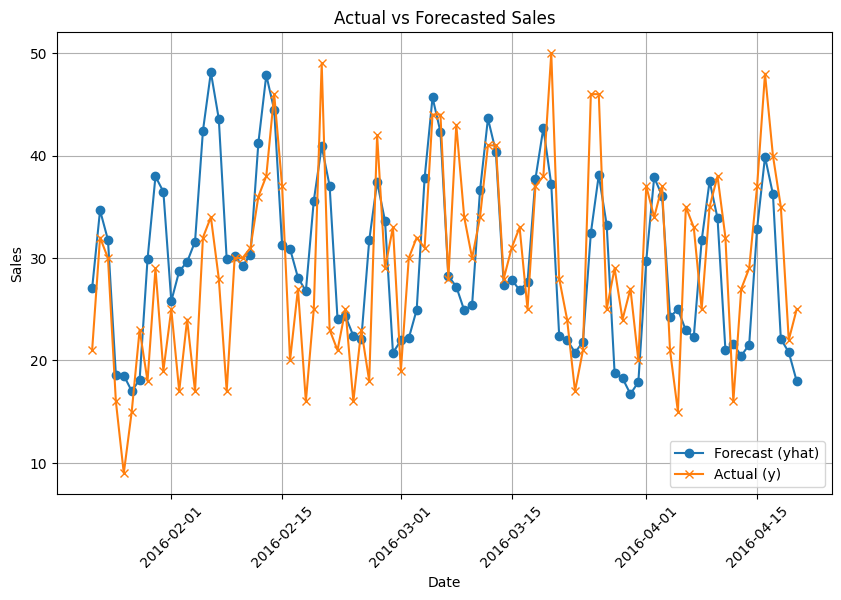

In [550]:
# Проверка пересечения дат
common_dates = test_store[test_store['ds'].isin(future['ds'])]
common_predictions = future[future['ds'].isin(common_dates['ds'])]

# Ensure both DataFrames have the same length
if len(common_dates) != len(common_predictions):
    print("Warning: Mismatched lengths between common dates and predictions.")
    common_dates = common_dates[common_dates['ds'].isin(common_predictions['ds'])]
    common_predictions = common_predictions[common_predictions['ds'].isin(common_dates['ds'])]

# Sort by date
common_dates = common_dates.sort_values(by='ds')
common_predictions = common_predictions.sort_values(by='ds')

# Вычисление метрик
mae = mean_absolute_error(common_dates['y'], common_predictions['yhat'])
rmse = np.sqrt(mean_squared_error(common_dates['y'], common_predictions['yhat']))
mape = np.mean(np.abs((common_dates['y'] - common_predictions['yhat']) / (common_dates['y'] + 0.01))) * 100

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}%')

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(future['ds'], future['yhat'], marker='o', linestyle='-', label='Forecast (yhat)')
plt.plot(common_dates['ds'], common_dates['y'], marker='x', linestyle='-', label='Actual (y)')
plt.title('Actual vs Forecasted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()  # Добавляем легенду, чтобы различать наборы данных
plt.show()